In [2]:
import sys
import os


sys.path.append(os.path.abspath("/Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation"))
from imports import *

In [4]:
file_path = '../Features/rabbit_corrvar.xlsx'
df = pd.read_excel(file_path)
df.head()

,Irritation,MaxAbsEStateIndex,MinAbsEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,AvgIpc,...,fr_ketone_Topliss,fr_methoxy,fr_nitro,fr_nitro_arom_nonortho,fr_para_hydroxylation,fr_pyridine,fr_sulfide,fr_sulfonamd,fr_unbrch_alkane,fr_urea
0,1,0.380977,0.301948,0.403803,0.385193,0.187251,0.199575,0.550820,0.588235,0.452681,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.277350,0.0
1,1,0.443959,0.118847,0.725612,0.470253,0.326442,0.202175,0.550534,0.560784,0.542612,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,1,0.049599,0.376730,0.440935,0.382546,0.249141,0.032276,0.304644,0.633987,0.404010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.160128,0.0
3,1,0.297132,0.200094,0.634828,0.454915,0.257268,0.120148,0.629576,0.650624,0.467685,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,1,0.067411,0.305414,0.501957,0.647698,0.225299,0.075490,0.315990,0.835294,0.471625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [5]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Irritation'])  # Assuming 'Call' is the target variable
y = df['Irritation']

In [57]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=5)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1424, 108)
Shape of X_test: (356, 108)
Shape of y_train: (1424,)
Shape of y_test: (356,)


In [58]:
import optuna
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

def objective(trial):
    # Define hyperparameter search space with stronger regularization
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),  # Reduce tree count
        "max_depth": trial.suggest_int("max_depth", 3, 5),  # Smaller trees
        "min_samples_split": trial.suggest_int("min_samples_split", 10, 50, step=5),  # Avoid small splits
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 20, step=5),  # Larger leaves
        "max_features": trial.suggest_categorical("max_features", ["sqrt"]),  # Always sqrt for simplicity
        "bootstrap": trial.suggest_categorical("bootstrap", [True]),  # Force bootstrap
        "max_samples": trial.suggest_float("max_samples", 0.5, 0.8)  # Reduce data seen per tree
    }

    # Set up cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    valid_scores = []

    for train_idx, valid_idx in kf.split(X_train, y_train):
        X_train_cv, X_valid_cv = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_cv, y_valid_cv = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        
        model = RandomForestClassifier(**param, random_state=42)
        model.fit(X_train_cv, y_train_cv)
        
        # Compute validation accuracy
        valid_acc = accuracy_score(y_valid_cv, model.predict(X_valid_cv))
        valid_scores.append(valid_acc)

    # Return mean validation accuracy
    return np.mean(valid_scores)

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print best hyperparameters
print("Best trial:", study.best_trial.params)


[I 2025-03-30 17:32:19,825] A new study created in memory with name: no-name-f96edc82-aaeb-4d35-8051-9245bbec6d1a
[I 2025-03-30 17:32:20,755] Trial 0 finished with value: 0.8139065974796145 and parameters: {'n_estimators': 175, 'max_depth': 4, 'min_samples_split': 40, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.6132667041850599}. Best is trial 0 with value: 0.8139065974796145.
[I 2025-03-30 17:32:21,253] Trial 1 finished with value: 0.8103953545836422 and parameters: {'n_estimators': 92, 'max_depth': 4, 'min_samples_split': 45, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.757125997995715}. Best is trial 0 with value: 0.8139065974796145.
[I 2025-03-30 17:32:22,181] Trial 2 finished with value: 0.8139115394119101 and parameters: {'n_estimators': 179, 'max_depth': 4, 'min_samples_split': 50, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.608614481658686}. Best is trial 2 with

Best trial: {'n_estimators': 89, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.7728229025790335}


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    
best_params = study.best_trial.params

    # Initialize the RandomForest model with the best parameters
final_model = RandomForestClassifier(**best_params)

    # Train the model
final_model.fit(X_train, y_train)


test_accuracy = final_model.score(X_test, y_test)
train_accuracy = final_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.8672752808988764
Test Accuracy: 0.8342696629213483


In [48]:
test_accuracies = []
train_accuracies = []

for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    
    best_params = study.best_trial.params

    # Initialize the RandomForest model with the best parameters
    final_model = RandomForestClassifier(**best_params)

    # Train the model
    final_model.fit(X_train, y_train)


    test_accuracy = final_model.score(X_test, y_test)
    train_accuracy = final_model.score(X_train, y_train)
    #print("Train Accuracy:", train_accuracy)
    #print("Test Accuracy:", test_accuracy)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

print(np.mean(train_accuracies), np.mean(test_accuracies))

0.8620786516853933 0.8314606741573034


In [37]:
# Initialize the RandomForest model with the best parameters
best_params = {'n_estimators': 62, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.747731027381931}
final_model = RandomForestClassifier(**best_params)

# Train the model
final_model.fit(X_train, y_train)

# Evaluate accuracy on test data
test_accuracy = final_model.score(X_test, y_test)
train_accuracy = final_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.8665730337078652
Test Accuracy: 0.8370786516853933


Train Accuracy: 0.8686797752808989
Test Accuracy: 0.8286516853932584


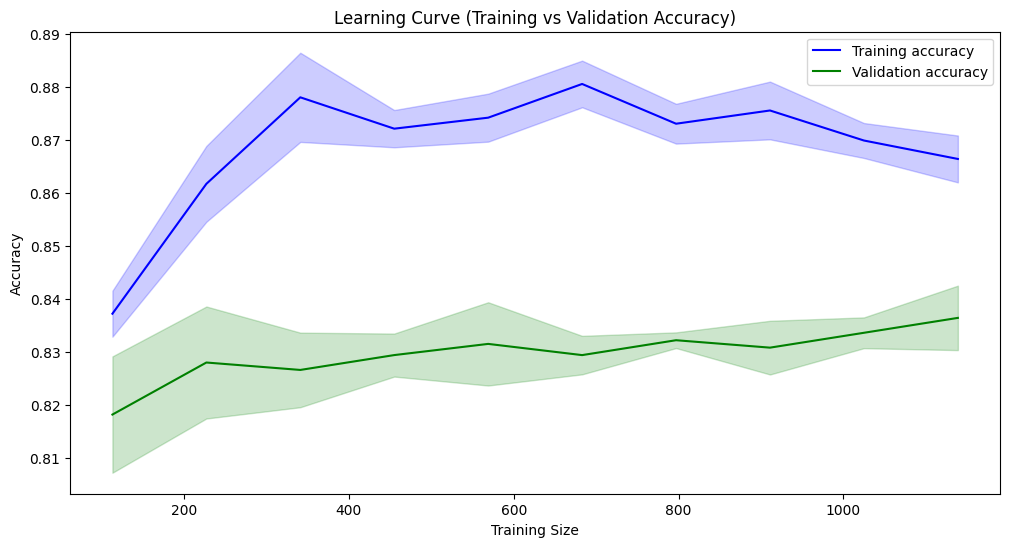

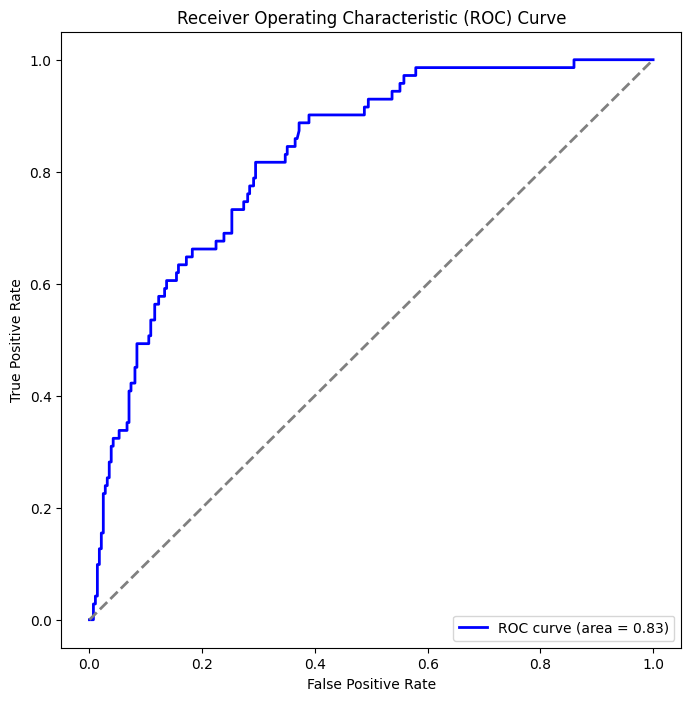

In [46]:
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import learning_curve
# Get best hyperparameters from study (assuming Optuna tuning)
best_params = study.best_trial.params

# Initialize the RandomForest model with the best parameters
final_model = RandomForestClassifier(**best_params)

# Train the model
final_model.fit(X_train, y_train)

# Evaluate accuracy on test data
test_accuracy = final_model.score(X_test, y_test)
train_accuracy = final_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# 1. Learning Curves
train_sizes, train_scores, validation_scores = learning_curve(
    final_model, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label='Training accuracy', color='blue')
plt.plot(train_sizes, validation_mean, label='Validation accuracy', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='green', alpha=0.2)
plt.title('Learning Curve (Training vs Validation Accuracy)')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 2. ROC Curve Plot
# Calculate ROC curve and AUC (Area Under the Curve)
fpr, tpr, thresholds = roc_curve(y_test, final_model.predict_proba(X_test)[:, 1])  # Get probabilities for positive class
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [15]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_train)  # Shape: (samples, features, 2)

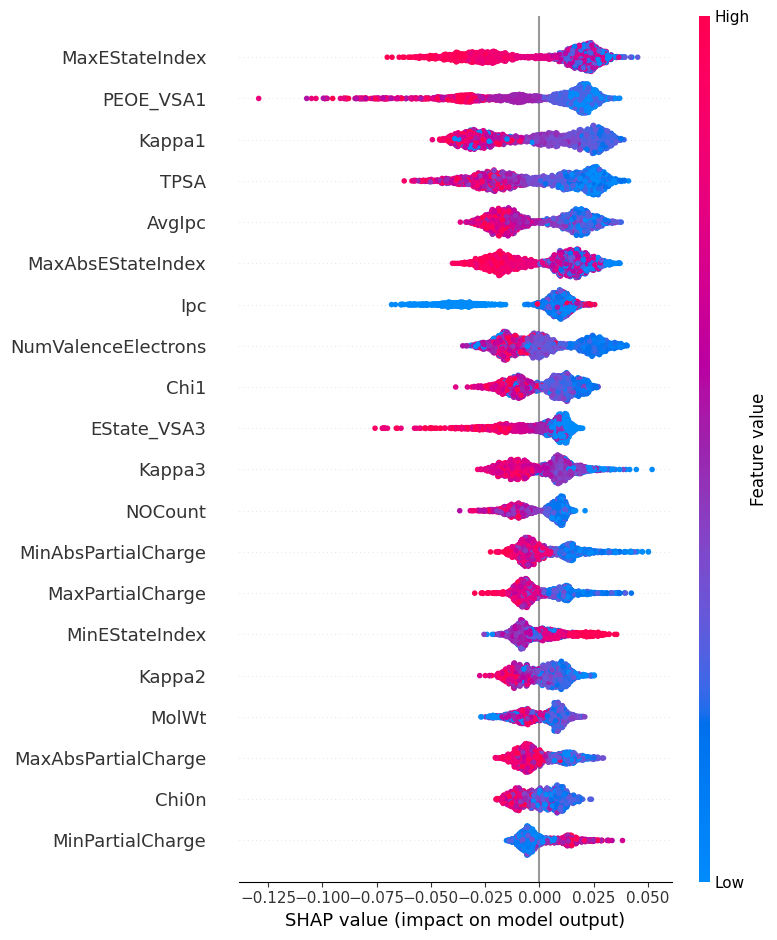

In [16]:
shap.summary_plot(shap_values[:,:,1], X_train)

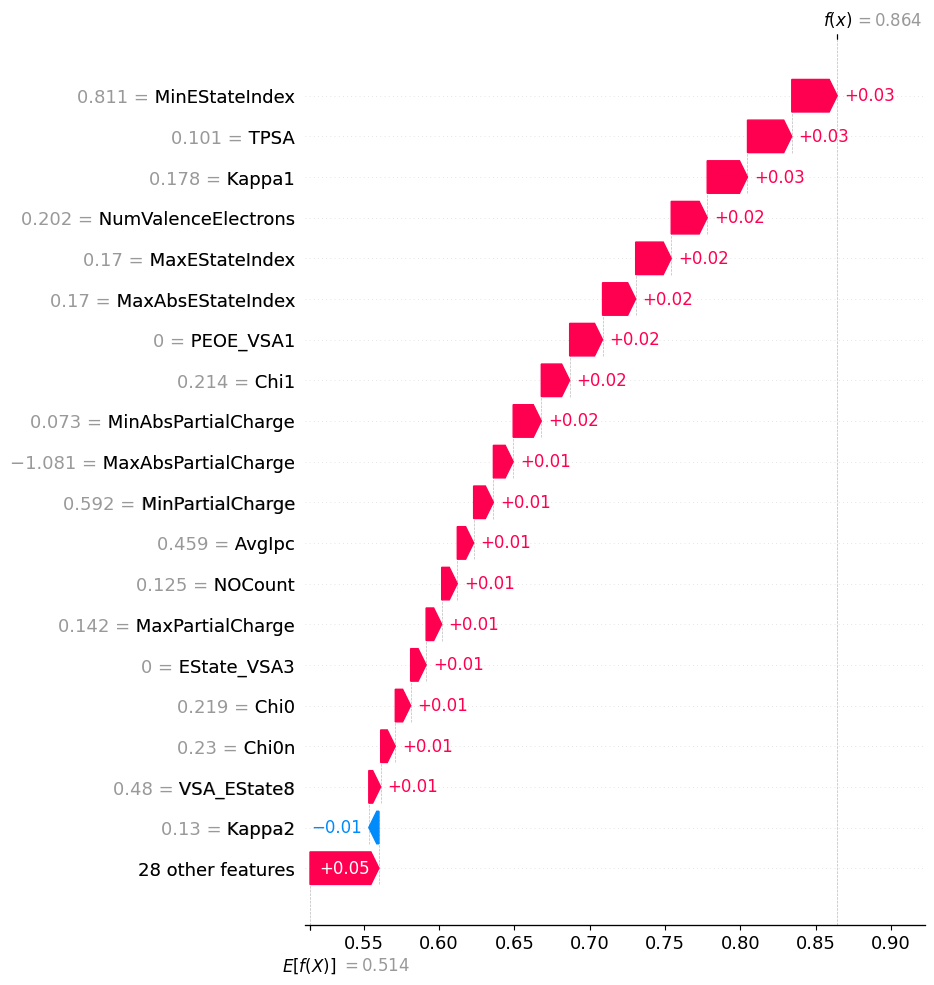

In [17]:
index = 0
shap.waterfall_plot(shap.Explanation(values=shap_values[index,:,1], base_values=explainer.expected_value[1], data=X_test.iloc[index,:]), max_display=20)

In [18]:
print(final_model.get_params())  # Replace "XGBoost" with any model name

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': 0.7987355391529141, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 35, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [22]:

important_hyperparams = [
    "n_estimators", "max_depth", "min_samples_split", "min_samples_leaf",
    "max_features", "bootstrap", "criterion", "oob_score",
    "random_state", "class_weight"
]

rf_hyperparams = {param: final_model.get_params()[param] for param in important_hyperparams}
rf_hyperparams

{'n_estimators': 50,
 'max_depth': 8,
 'min_samples_split': 35,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'bootstrap': True,
 'criterion': 'gini',
 'oob_score': False,
 'random_state': None,
 'class_weight': None}

In [60]:
import joblib

# Assuming 'model' is your trained QSAR model
joblib.dump(final_model, 'rf_model.pkl')

print("Model saved successfully!")


Model saved successfully!


In [31]:
FEATURE_COLUMNS = [desc[0] for desc in Descriptors.descList] 

In [32]:
def process_input(input):    
    mol = Chem.MolFromSmiles(input)
    if mol is None:
        raise ValueError("Invalid Input")

    # Compute descriptors and create a DataFrame with one row
    descriptor_values = [func(mol) for _, func in Descriptors.descList]
    feature_df = pd.DataFrame([descriptor_values], columns=FEATURE_COLUMNS)

    original_names = list(feature_df.columns)
    names_to_delete = []

    with open("feature_names.txt", "r", encoding="utf-8", errors="ignore") as file:
        names = file.read().splitlines() 
        
    for name in original_names:
        if name not in names:
            names_to_delete.append(name)
    
    feature_df.drop(columns=names_to_delete, inplace=True)
    df_sorted = feature_df[names]

    return df_sorted  # Returns a DataFrame

In [53]:
df.head()

,Irritation,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,SPS,MolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,...,RingCount,MolLogP,fr_C_O,fr_C_O_noCOO,fr_NH0,fr_NH1,fr_amide,fr_aniline,fr_ether,fr_halogen
0,0,0.545511,0.223433,0.490223,0.390551,0.291325,0.250000,0.472316,0.592036,-1.017995,...,0.447214,0.451534,0.0,0.000000,0.707107,0.0,0.0,0.0,0.000000,0.707107
1,1,0.591920,0.253125,0.601726,0.389406,0.277681,0.278846,0.315886,0.215424,1.052267,...,0.447214,0.416318,0.5,0.707107,0.000000,0.0,0.0,0.0,0.707107,0.000000
2,1,0.553126,0.334919,0.502072,0.400859,0.399452,0.278846,0.472195,0.592036,-1.018511,...,0.447214,0.475805,0.0,0.000000,0.707107,0.0,0.0,0.0,0.000000,0.707107
3,0,0.612445,0.602032,0.496240,0.408749,0.461148,0.423077,0.676377,0.290413,0.491735,...,0.000000,0.560347,0.5,0.707107,0.000000,0.0,0.0,0.0,0.707107,0.000000
4,0,0.618170,0.914475,0.141109,0.000000,0.000000,0.000000,0.354992,0.378416,-0.071536,...,0.000000,0.225586,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000


In [54]:
df_f

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,SPS,MolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,FpDensityMorgan1,...,RingCount,MolLogP,fr_C_O,fr_C_O_noCOO,fr_NH0,fr_NH1,fr_amide,fr_aniline,fr_ether,fr_halogen
0,9.641317,0.906062,-0.906062,15.9375,220.356,90,0.09805,-0.381961,0.381961,1.3125,...,0,4.1723,0,0,0,0,0,0,0,0


In [67]:
def process_input(input_smiles):    
    mol = Chem.MolFromSmiles(input_smiles)
    if mol is None:
        raise ValueError("Invalid Input")

    # Compute descriptors and create a DataFrame with one row
    descriptor_values = [func(mol) for _, func in Descriptors.descList]
    feature_df = pd.DataFrame([descriptor_values], columns=[name for name, _ in Descriptors.descList])

    # Read feature names from file
    with open("feature_names.txt", "r", encoding="utf-8", errors="ignore") as file:
        valid_columns = file.read().splitlines() 

    # Keep only the columns present in feature_df and in valid_columns
    valid_columns = [col for col in valid_columns if col in feature_df.columns]
    feature_df = feature_df[valid_columns]  # Select and reorder columns

    return feature_df

In [79]:
df_f = df_f.reindex(columns=final_model.feature_names_in_, fill_value=0)

In [77]:
from collections import Counter
print(Counter(y_train))  # Replace y_train with your actual training labels

Counter({1: 1025, 0: 964})


In [85]:
smiles_list = [
    "CCCCCCC=O", 
    "CC(CC1=CC=C(C=C1)C(C)(C)C)C=O", 
    "CCCCCBr", 
    "CC(CCC=C(C)C)CCO", 
    "CC1=CCC(CC1)C(=C)C", 
    "CSSC", 
    "CC(C)(CCC1=CC=CC=C1)O", 
    "CC1=CC(=C(C=C1)N)C", 
    "CC(CCCC(C)(C)O)CC=O", 
    "C(CSSCCC(=O)O)C(=O)O", 
    "C1=NN=CN1N", 
    "C1=CC(=CC(=C1)Cl)[N+](=O)[O-]", 
    "CC1=CCC(C1(C)C)/C=C/C(C)(C)C(C)O", 
    "CC(=CCC/C(=C/C=C/C(C)(C=C)O)/C)C", 
    "C1CCC(C1)OCCC2=CC=CC=C2", 
    "C(CCCBr)CCBr", 
    "C=CCCCCCCCCC(=O)O", 
    "CC(CO)COC1CC2CCC1(C2(C)C)C", 
    "CC1=C(NN=C1)C", 
    "CC1C2CC3CC1C(C(C2)C3=C)OC(=O)C", 
    "CC1C2CC3CC1C(C(C2)C3=C)O", 
    "CC(C)C1=CC=C(C=C1)CC(C)C=O", 
    "C(CCBr)CCl", 
    "CCOC(=O)C1=CC=CC=C1C(=O)OCC", 
    "CCCCCCCCC(=O)OCCCOCCCOC(=O)CCCCCCCC", 
    "C1=CC=C2C(=C1)C=CC=C2CC(=O)O", 
    "CC(C)(C)C1=CC(=CC(=C1O)C(C)(C)C)CC2=CC(=C(C(=C2)C(C)(C)C)O)C(C)(C)C", 
    "C1=CC=C(C=C1)COC(=O)C2=CC=CC=C2", 
    "C=CCCC=C", 
    "C(CO)O", 
    "C(C(CO)O)O", 
    "CCC(C)(C)CC", 
    "C=CCOC(=O)COC1=CC=CC=C1", 
    "C1=CC=C(C=C1)COC(=O)C2=CC=CC=C2O", 
    "CCCCCCCCCCCC(=O)O", 
    "CSC1=CC=C(C=C1)C=O", 
    "CCCCCCCCCCCCCCCCCC(=O)OC", 
    "CC(=O)OCC1=CC=CC=C1", 
    "CCCCCCCCCCCCCC(=O)OC(C)C", 
    "CCCCCCCCCCCCCCCC(=O)OC(C)C", 
    "CCCCOC(=O)CC", 
    "C1=CC=C(C=C1)CO", 
    "CCCCCCC(=O)OCC=C", 
    "CCCCCCCOC(=O)CCC", 
    "CCOCCOC(=O)C(=C)C", 
    "CCCCCCOC(=O)C1=CC=CC=C1O", 
    "CC(C)COP(=O)(OCC(C)C)OCC(C)C", 
    "CC(=CCCC(C)(C=C)O)C", 
    "C1=CC=C(C=C1)/C=C/C=O", 
    "CCCCCCCCCCO", 
    "CCCCCCBr", 
    "CC1=CCC(CC1)C(C)(C)O", 
    "CC1=CN=C(C(=C1OC)C)CCl.Cl", 
    "CCCCOC(=O)C(=C)C", 
    "CCCSSCCC", 
    "CC1=C(C=C(C=C1)C(C)(C)C)S", 
    "CN1CCNC(C1)C2=CC=CC=C2", 
    "CC(Cl)(Cl)Cl", 
    "CC(CN)N", 
    "CC(C)(C)C1=CC=CC=C1O", 
    "CCCCCCCCCCCCCCCC(=O)OC", 
    "[OH-].[K+]", 
    "CC(C)(C)CC(C)(C)C1=CC=C(C=C1)OCCO", 
    "CCCCCCCCCCCCOS(=O)(=O)[O-].[Na+]", 
    "COC1=CC=CC=C1O", 
    "CC(C)(C(=O)O)O", 
    "C(=O)(C(=O)O)O.O.O", 
    "C(CC(=O)O)C(=O)C(=O)O", 
    "NS(=O)(=O)O", 
    "C=CCCCCCCCCC(=O)[O-].[Na+]", 
    "C1=CC=C(C=C1)CCO", 
    "CN(C)CC1=CC=CC=C1", 
    "[H+].[B-](F)(F)(F)F", 
    "C1=CC(=O)OC1=O", 
    "CC(C)N(C)C", 
    "Cl", 
    "CCCCCCCN", 
    "CCCCCCCC(=O)O", 
    "CC1=C(C=C(C=C1)C(C)C)O", 
    "CC(=C)C=O", 
    "CC(C(=O)O)O", 
    "O.OS(=O)(=O)[O-].[Na+]", 
    "C(=O)C(=O)O.O", 
    "OS(=O)(=O)[O-].[Na+]", 
    "C1CCC(CC1)N", 
    "CCC(C)C(=O)O", 
    "C(COC(=O)CBr)OC(=O)CBr", 
    "COCCCN", 
    "C=CCBr", 
    "C1CN(CCN1)CCN", 
    "Cl[Fe](Cl)Cl", 
    "OP(=O)(O)O", 
    "CCC(=O)O", 
    "CCCC(=O)O", 
    "B(F)(F)F.CC(=O)O.CC(=O)O", 
    "C(CO)N", 
    "Br", 
    "P(Br)(Br)Br", 
    "B(F)(F)F.O.O", 
    "C=CC(=O)O", 
    "C(=O)O", 
    "C(C(=O)Cl)(Cl)Cl", 
    "[N+](=O)([O-])[O-].[Ag+]", 
    "C1=CC=C(C=C1)O", 
    "CC(=O)O", 
    "C(C(=O)O)Br", 
    "CN(C)CCCNCCCN", 
    "OS(=O)(=O)O", 
    "C1CC(C2=CC=CC=C2C1)N", 
    "[B]1OC2=CC=CC=C2O1", 
    "C1CCC(=O)CC1", 
    "C1=CC=C(C(=C1)C(C(=O)O)O)Cl", 
    "CNCCC(C1=CC=CC=C1)OC2=CC=C(C=C2)C(F)(F)F.Cl", 
    "[Cl-].[Cl-].[Cl-].[Cr+3]", 
    "CCCCCC(=O)O", 
    "CCC(C)C(=O)O", 
    "P(Cl)(Cl)(Cl)(Cl)Cl", 
    "C(C[S-])O.[Na+]", 
    "C(#N)S.C(=N)(N)N", 
    "CCCCCCCCCCCCN(CCCN)CCCN", 
    "C(=C(Cl)Cl)(Cl)Cl", 
    "CCCCCCCCCCCC(=O)OC", 
    "CC(=CCCC(C)(C=C)OC(=O)C)C", 
    "COC1=C(C=CC(=C1)CC=C)O", 
    "[O-][Si](=O)[O-].[Na+].[Na+]", 
    "OS(=O)[O-].[Na+]", 
    "C(CCCBr)CCBr", 
    "CC(C)O", 
    "C(=O)(O)[O-].[Na+]", 
    "C1=CC=C2C(=C1)C=CC=C2CC(=O)O", 
    "CCCCCCCOC(=O)CCC", 
    "CCOC(=O)C1=CC=CC=C1C(=O)OCC", 
    "CCCCCCOC(=O)C1=CC=CC=C1O", 
    "CC(C)C1=CC=C(C=C1)CC(C)C=O", 
    "CCCCCC(=O)OC", 
    "CCCCCCCCCC(=O)O", 
    "CS(=O)C", 
    "[OH-].[Na+]", 
    "CCCCCCC(=O)O", 
    "C(CO)N(CCO)CCO", 
    "CCCCCCCCCCCCO", 
    "CCCCCCCCC=CCCCCCCCC(=O)OCCOCC(C1C(C(CO1)OCCO)OCCO)OCCO", 
    "CCCCCCCCCCCC"
]

In [97]:
smiles_list[86]

'C(COC(=O)CBr)OC(=O)CBr'

In [92]:
import numpy as np

# Test the model on a range of inputs
test_inputs = [process_input(smiles) for smiles in smiles_list]
predictions = final_model.predict(np.vstack(test_inputs))  # Assuming multiple samples

print(predictions)


[15:16:29] WARNING: not removing hydrogen atom without neighbors
[15:16:29] WARNING: not removing hydrogen atom without neighbors
[15:16:29] WARNING: not removing hydrogen atom without neighbors


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [80]:
print(final_model.predict_proba(df_f))


[[0.65577993 0.34422007]]


In [71]:
same_columns = list(X.columns) == list(df_f.columns)

print(same_columns)

True
